Root-finding without Derivatives
================================

**References:**

- Section 1.5 *Root-finding without Derivatives* of {cite}`Sauer`.
- The second part of Section 2.3 *Newton's Method and Its Extensions* in {cite}`Burden-Faires`,
about the Secant method.

## Introduction

In section {doc}`root-finding-by-interval-halving`) we have seen one method for solving $f(x) = 0$ without needing to know any derivatives of $f$:
the *Bisection Method* a.k.a. *Interval Halving*.

However, we have also seen that that method is far slower then Newton's Method;
here we explore methods that are almost the best of both worlds:
about as fast as Newton's method but not needing derivatives.

The first of these is the Secant Method.
Later in this course we will see how this has been merged with the Bisection Method and
[Polynomial Interpolation](polynomial-collocation+approximation.ipynb)
to produce the current state-of-the-art approach;
only perfected in the 1960's.

In [57]:
using PyPlot

## Using Linear Approximation Without Derivatives

One quirk of the
[Bisection Method](root-finding-by-interval-halving.ipynb)
is that it only used the sign of the values $f(a)$ and $f(b)$, not their magnitudes.
If one of these is far smaller than the other, one might guess that the root is closer to that end of the interval.
This leads to the idea of:
- starting with an interval $[a, b]$ known to contain a zero of $f$,
- connecting the two points $(a, f(a))$ and $(b, f(b))$ with a straight line, and
- finding the $x$-value $c$ where this line crosses the $x$-axis.
In the words, aproximating the function by a *secant line*, in place of the *tangent line* used in Newton's Method.

<a name="method-of-false-position"></a>
### First Attempt: The Method of False Position

The next step requires some care.
The first idea (from almost a millenium ago) was to use this new approximation $c$ as done with bisection:
check which of the intervals $[a, c]$ and $[c,b]$ has the sign change and use it as the new interval $[a, b]$;
this is called *The Method of False Position* (or *Regula Falsi*, since the academic world used latin in those days.)

The secant line between $(a, f(a))$ and $(b, f(b))$ is

$$
L(x) = \frac{f(a)(b-x) + f(b)(x-a)}{b-a}
$$

and its zero is at

$$
c = \frac{a f(b) - f(a) b}{f(b) - f(a)}
$$

This is easy to implement, and an example will show that it sort of works, but with a weakness that hampers it a bit:

Some helper functions for displaying numbers

In [70]:
roundoff(x) = round(x, sigdigits=12);  # Rounding off output to 12 significant digits, to clean up output
round3(x) = round(x, sigdigits=3);  # For rounding off errors,wher only a few significant digits are needed

In [71]:
function falseposition(f, a, b, errortolerance; maxiterations=10, demomode=false)
    # Solve f(x)=0 in the interval [a, b] by the Method of False Position.
    # This code also illustrates a few ideas that I encourage, such as:
    # - Avoiding infinite loops, by using for loops sand break
    # - Avoiding repeated evaluation of the same quantity
    # - Use of descriptive variable names
    # - Use of "camelCase" to turn descriptive phrases into valid Julia variable names
    # - An optional "demonstration mode" to display intermediate results.

    if demomode
        println("Solving by the Method of False Position.")
    end;
    fa = f(a)
    fb = f(b)
    global c, errorbound  # So that they persist after the end of the following for loop!
    for iteration in 1:maxiterations
        if demomode
            println("\nIteration $iteration:")
        end;
        c = (a * fb - fa * b)/(fb - fa)
        fc = f(c)
        if fa * fc < 0
            b = c
            fb = fc  # N.B. When b is updated, so must be fb = f(b)
        else
            a = c
            fa = fc
        end;
        errorbound = b - a
        if demomode
            println("The root is in interval [$(roundoff(a)), $(roundoff(b))]")
            println("The new approximation is $(roundoff(c)) with error bound $(round3(errorbound)), backward error $(round3(abs(fc)))")
        end
        if errorbound <= errortolerance
            break
        end;
    end;
    # Whether we got here due to accuracy of running out of iterations,
    # return the information we have, including an error bound:
    root = c  # the newest value is probably the most accurate
    return (root, errorbound)
end;

In [72]:
f(x) = x - cos(x)
a = -1.0
b = 1.0;

In [73]:
errortolerance = 1e-12
(root, errorbound) = falseposition(f, a, b, errortolerance; demomode=true)
println()
println("The Method of False Position gave approximate root $root")
println(" with estimate error $errorbound and backward error $(abs(f(root)))")

Solving by the Method of False Position.

Iteration 1:
The root is in interval [0.540302305868, 1.0]
The new approximation is 0.540302305868 with error bound 0.46, backward error 0.317

Iteration 2:
The root is in interval [0.728010361468, 1.0]
The new approximation is 0.728010361468 with error bound 0.272, backward error 0.0185

Iteration 3:
The root is in interval [0.738527006242, 1.0]
The new approximation is 0.738527006242 with error bound 0.261, backward error 0.000934

Iteration 4:
The root is in interval [0.739057166678, 1.0]
The new approximation is 0.739057166678 with error bound 0.261, backward error 4.68e-5

Iteration 5:
The root is in interval [0.739083732278, 1.0]
The new approximation is 0.739083732278 with error bound 0.261, backward error 2.34e-6

Iteration 6:
The root is in interval [0.739085063039, 1.0]
The new approximation is 0.739085063039 with error bound 0.261, backward error 1.17e-7

Iteration 7:
The root is in interval [0.7390851297, 1.0]
The new approximation 

The good news is that the approximations are approaching the zero reasonably fast — far faster than bisection —
as indicated by the backward errors improving by a factor of better than ten at each iteration.

The bad news is that one end gets "stuck", so the interval does not shrink on both sides, and the error bound stays large.

This behavior is generic: with function $f$ of the same convexity on the interval $[a, b]$, the secant line will always cross on the same side of the zero, so that one end-point persists;
in this case, the curve is concave up, so the secant line always crosses to the left of the root, as seen in the following graphs.

In [74]:
function graphfalseposition(f, a, b; maxiterations=3)
    # Graph a few iterations of the Method of False Position for solving f(x)=0 in the interval [a, b].

    fa = f(a)
    fb = f(b)
    for iteration in 1:maxiterations
        c = (a * fb - fa * b)/(fb - fa)
        fc = f(c)
        abc = [a b c]
        # TODO: find min, max in julia!
        left = min(a, b)
        right = max(a, b)
        xplot = range(left, right, 100);
        figure(figsize=[12,6])
        grid(true)
        title("Method of False Position Iteration $iteration")
        xlabel("x")
        plot(xplot, f.(xplot))
        plot([left, right], [f(left), f(right)])  # the secant line
        plot([left, right], [0, 0], "k")  # the x-axis line
        plot(abc, f.(abc), "r*")
        #show()  # The Windows version of JupytLab might need this command; it is harmless anyway.
        if fa * fc < 0
            b = c
            fb = fc  # N.B. When b is updated, so must be fb = f(b)
        else
            a = c
            fa = fc
        end;
    end;
end;

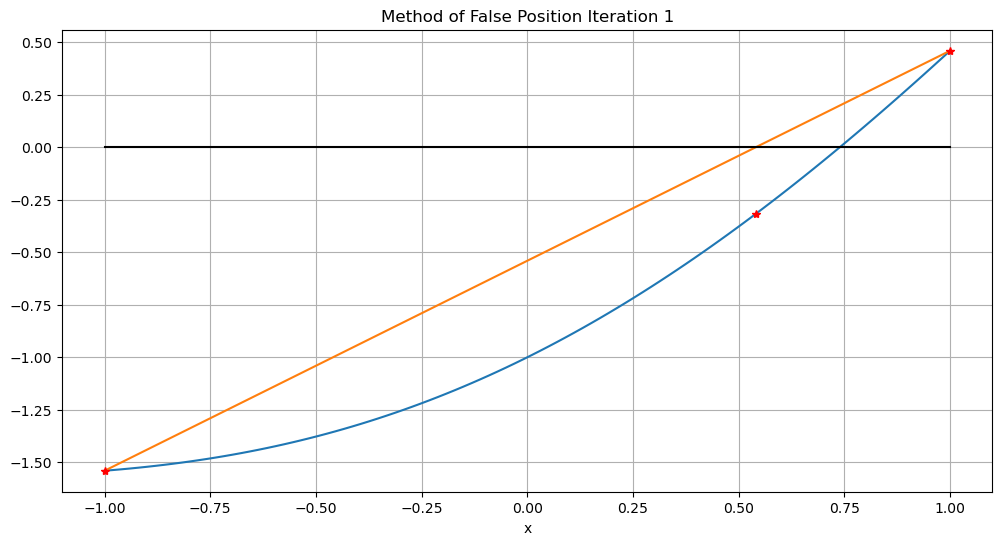

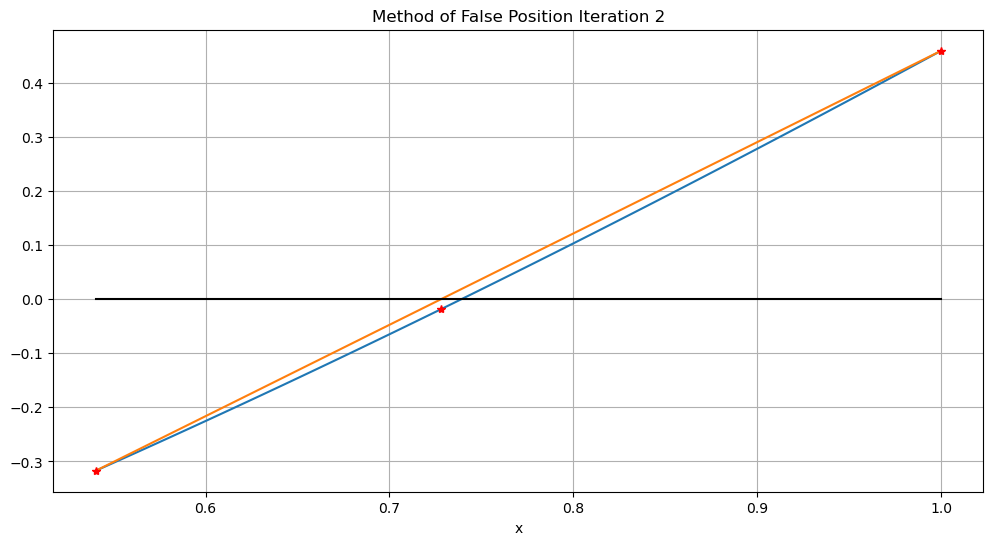

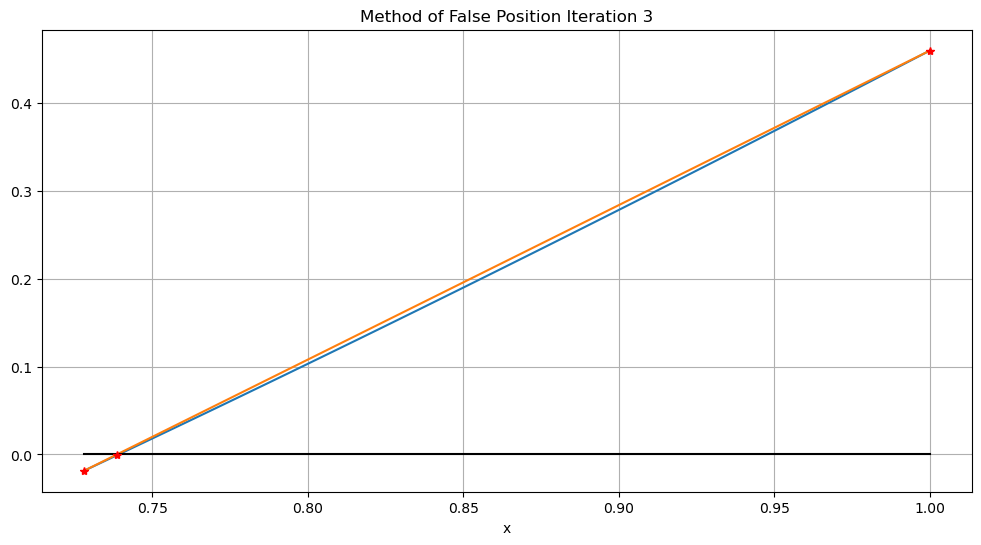

In [75]:
graphfalseposition(f, a, b)

### Refinement: Alway Use the Two Most Recent Approximations — The Secant Method

The basic solution is to always discard the oldest approximation — at the cost of not always having the zero surrounded!
This gives the Secant Method.

For a mathemacal description, one typically enumerates the successive approximations as $x_0$, $x_1$, etc.,
so the notation above gets translated with $a \to x_{k-2}$, $b \to x_{k-1}$, $c \to x_{k}$;
then the formula becomes the recursive rule

$$
x_k = \frac{x_{k-2} f(x_{k-1}) - f(x_{k-2}) x_{k-1}}{f(x_{k-1}) - f(x_{k-2})}
$$

Two difference from above:
- previously we could assume that $a<b$, but now we do not know the order of the various $x_k$ values, and
- the root is not necessarily bewtween the two most recent values, so we no longer have tht simple error bound.
(In fact, we will see that the zero is typically surrounded two-thirds of the time!)

Instead, we use the *magnitude* of $b-a$ which is now $|x_k - x_{k-1}|$, and this is only an *estimate* of the error.
This is the same as used for Newton's Method; as there, it is still useful as a condition for ending the iterations and indeed tends to be pessimistic, so that we typically do one more iteration than needed — but it is not on its own a complete guarantee of having achieved the desired accuracy.

### Pseduo-code for a Secant Method Algorithm

````{prf:algorithm} Secant Method
:label: secant-method

Input function $f$, interval endpoints $x_0$ and $x_1$, an error tolerance $E_{tol}$, and an iteration limit $N$

for k from 2 to N
<br>
$\quad$ $\displaystyle x_k \leftarrow \frac{x_{k-2} f(x_{k-1}) - f(x_{k-2}) x_{k-1}}{f(x_{k-1}) - f(x_{k-2})}$
<br>
$\quad$ Evaluate the error estimate $E_{est} \leftarrow |x_k - x_{k-1}|$
<br>
$\quad$ if $E_{est} \leq E_{tol}$
<br>
$\quad\quad$ End the iterations
<br>
$\quad$ else
<br>
$\quad\quad$ Go around another time
<br>
$\quad$ end
<br>
end
<br>
Output the final $x_k$ as the approximate root and $E_{est}$ as an estimate of its absolute error.
````

### Julia Code for this Secant Method Algorithm

We could write Julia code that closely follows this notation,
accumulating a list of the values $x_k$.

However, since we only ever need the two most recent values to compute the new one, we can instead just store these three,
in the same way that we recylced the variables `a`, `b` and `c`.
Here I use more descriptive names though:

In [76]:
function secantmethod(f, a, b, errortolerance; maxiterations=20, demomode=false)
    # Solve f(x)=0 in the interval [a, b] by the Secant Method.

    if demomode
        print("Solving by the Secant Method.")
    end;
    # Some more descriptive names
    x_older = a
    x_more_recent = b
    f_x_older = f(x_older)
    f_x_more_recent = f(x_more_recent)
    for iteration in 1:maxiterations
        global x_new, errorestimate
        if demomode
            println("\nIteration $(iteration):")
        end;
        x_new = (x_older * f_x_more_recent - f_x_older * x_more_recent)/(f_x_more_recent - f_x_older)
        f_x_new = f(x_new)
        (x_older, x_more_recent) = (x_more_recent, x_new)
        (f_x_older, f_x_more_recent) = (f_x_more_recent, f_x_new)
        errorestimate = abs(x_older - x_more_recent)
        if demomode
            println("The latest pair of approximations are $(roundoff(x_older)) and $(roundoff(x_more_recent)),")
            println("where the function's values are $(roundoff(f_x_older)) and $(roundoff(f_x_more_recent)) respectively.")
            print("The new approximation is $(roundoff(x_new)),")
            println("with estimated error $(round3(errorestimate)) and backward error $(round3(abs(f_x_new)))")
        end;
        if errorestimate < errortolerance
            break
        end;
    end;
    # Whether we got here due to accuracy of running out of iterations,
    # return the information we have, including an error estimate:
    return (x_new,  errorestimate)
end;

In [77]:
errortolerance = 1e-12
(root, errorestimate) = secantmethod(f, a, b, errortolerance, demomode=true)

println()
println("The Secant Method gave approximate root $root,")
print("with estimated error $errorestimate, backward error $(abs(f(root)))")

Solving by the Secant Method.
Iteration 1:
The latest pair of approximations are 1.0 and 0.540302305868,
where the function's values are 0.459697694132 and -0.317250909978 respectively.
The new approximation is 0.540302305868,with estimated error 0.46 and backward error 0.317

Iteration 2:
The latest pair of approximations are 0.540302305868 and 0.728010361468,
where the function's values are -0.317250909978 and -0.0184893945776 respectively.
The new approximation is 0.728010361468,with estimated error 0.188 and backward error 0.0185

Iteration 3:
The latest pair of approximations are 0.728010361468 and 0.739627012631,
where the function's values are -0.0184893945776 and 0.000907004400407 respectively.
The new approximation is 0.739627012631,with estimated error 0.0116 and backward error 0.000907

Iteration 4:
The latest pair of approximations are 0.739627012631 and 0.739083800783,
where the function's values are 0.000907004400407 and -2.22997338051e-6 respectively.
The new approximati

Alternatively, you get a version of `secantmethod` from the module `NumericalMethods` with

    import .NumericalMethods: secantmethod

In [78]:
function graphsecantmethod(f, a, b; maxiterations=5)
    # Graph a few iterations of the Secant Method for solving f(x)=0 in the interval [a, b].
    
    x_older = a
    x_more_recent = b
    f_x_older = f(x_older)
    f_x_more_recent = f(x_more_recent)
    for iteration in 1:maxiterations
        x_new = (x_older * f_x_more_recent - f_x_older * x_more_recent)/(f_x_more_recent - f_x_older)
        f_x_new = f(x_new)
        latest_three_x_values = [x_older x_more_recent x_new]
        left = min(x_older, x_more_recent, x_new)
        right = max(x_older, x_more_recent, x_new)
        xplot = range(left, right, 100);
        figure(figsize=[12,6])
        grid(true)
        title("Secant Method iteration $iteration")
        xlabel("x")
        plot(xplot, f.(xplot))
        plot([left, right], [f(left), f(right)])  # the secant line
        plot([left, right], [0, 0], "k")  # the x-axis line
        plot(latest_three_x_values, f.(latest_three_x_values), "r*")
        x_older = x_more_recent
        f_x_older = f_x_more_recent
        x_more_recent = x_new
        f_x_more_recent = f_x_new
        errorEstimate = abs(x_older - x_more_recent)
    end;
end;

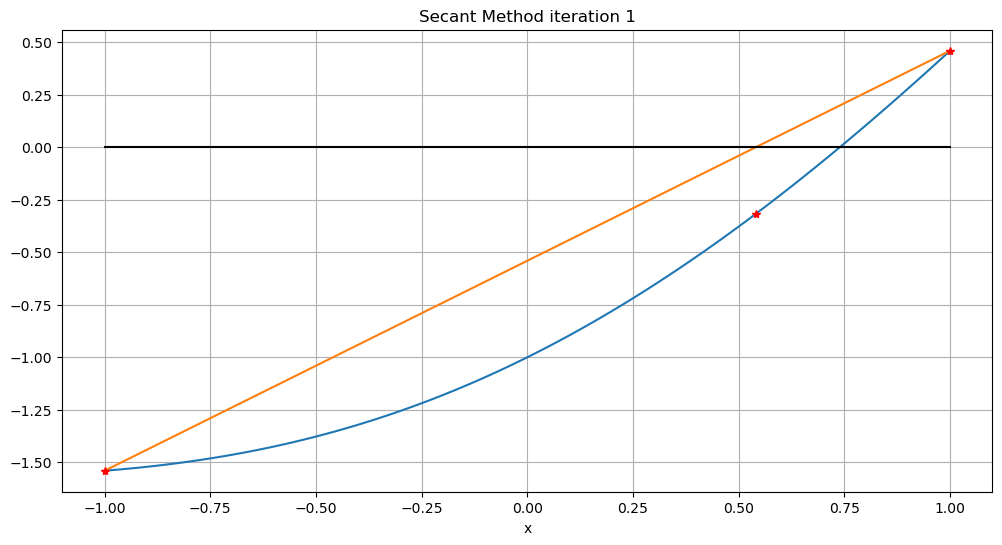

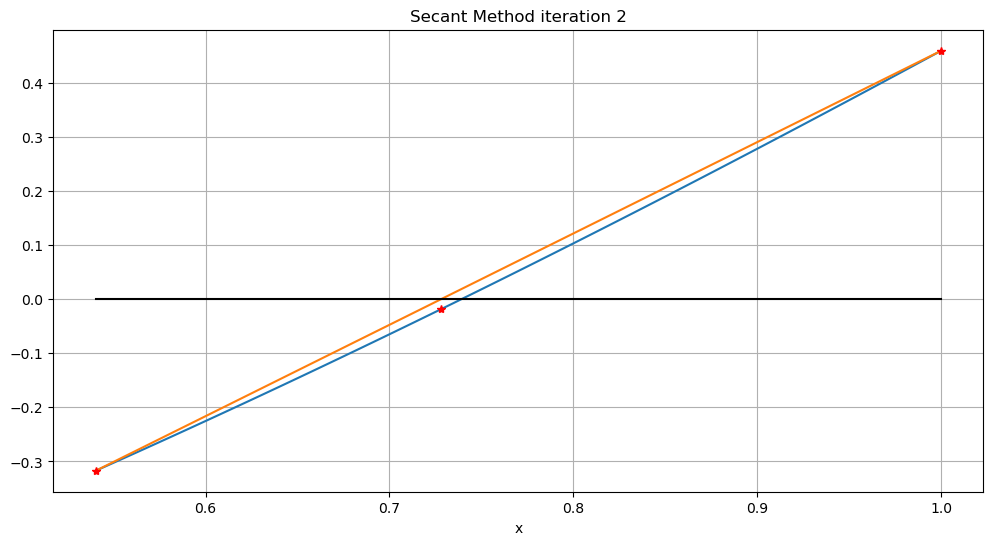

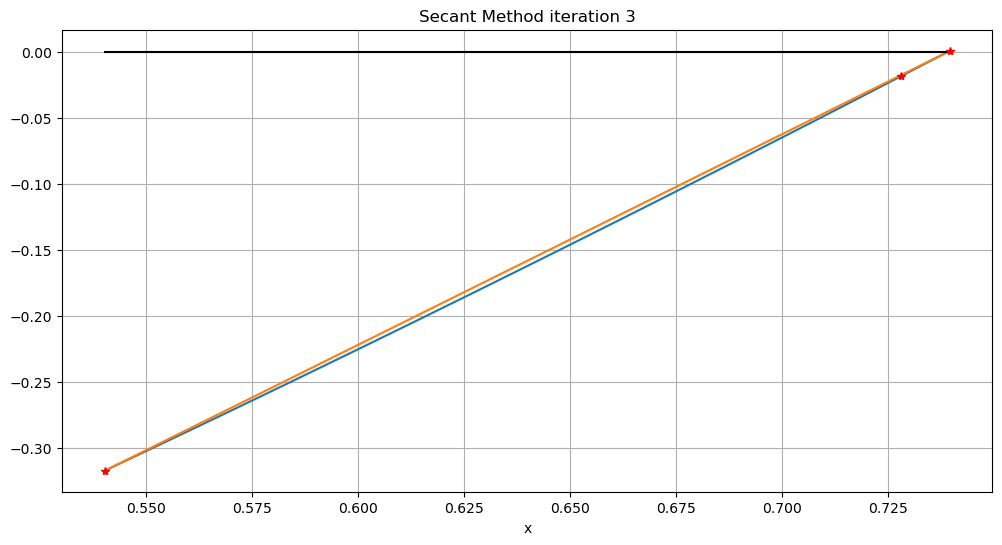

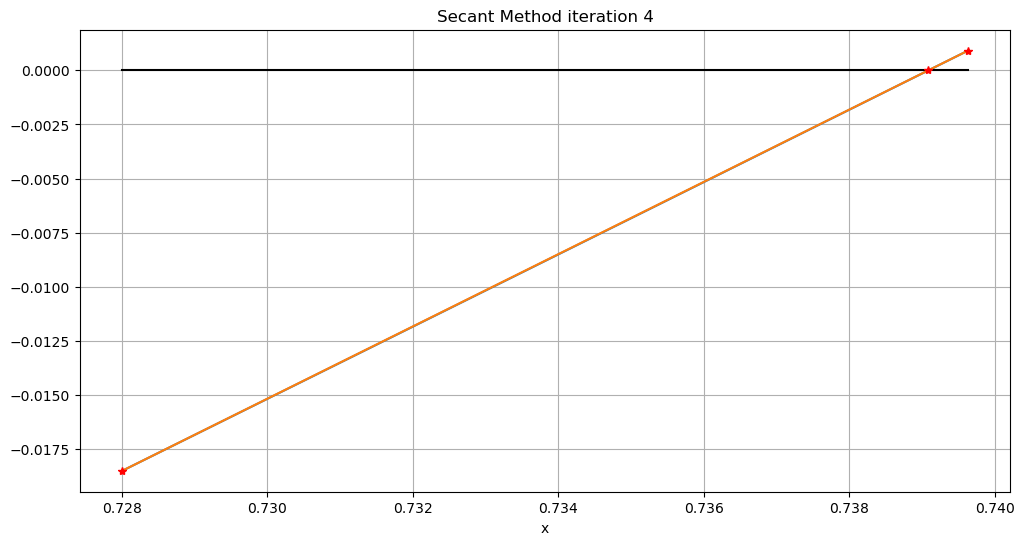

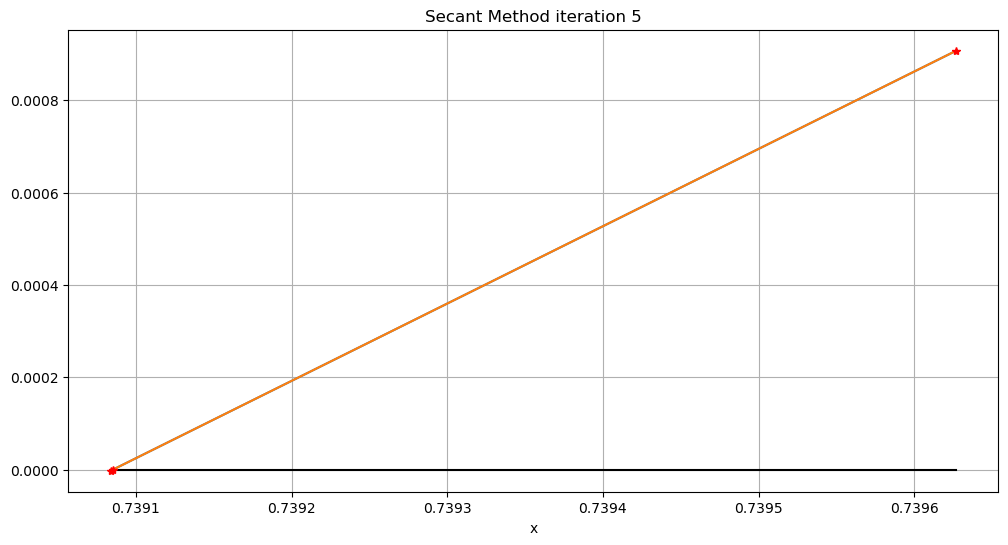

In [79]:
graphsecantmethod(f, a, b)

```{prf:observation}

- This converges faster than the [Method of False Position](#method-of-false-position) (and far faster than Bisection).
- The majority of iterations have the root surrounded (sign-change in $f$), but every third one — the second and fifth — do not.
- Comparing the error estimate to the backward error, the error estimate is quite pessimistic (and so fairly trustworthy);
in fact, it is typically of similar size to the backward error at the *previous* iteration.

The last point is a quite common occurence: the available error estimates are often "trailing indicators",
closer to the error in the previous approximation in an iteration.
For example, recall that we saw the same thing with Newton's Method when we used $|x_k - x_{k-1}|$ to estimate the error $E_k := x_k - r$ and saw that it is in fact closer to the previous error, $E_{k-1}$.
```